In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import json
from textblob import TextBlob
from sklearn.cross_validation import cross_val_score
import metrics
from sklearn.cross_validation import train_test_split

plt.rcParams["figure.figsize"] = (10, 8)

In [2]:
def contest_metric(numpy_array_predictions, numpy_array_actual_values):
    return metrics.weighted_rmsle(numpy_array_predictions, numpy_array_actual_values,
            weights=metrics.KEEPING_IT_CLEAN_WEIGHTS)

In [3]:
def contest_scoring(X, y, pipeline):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    s1 = pipeline.fit(X_train, y_train['score_lvl_1']).predict(X_test)
    s2 = pipeline.fit(X_train, y_train['score_lvl_2']).predict(X_test)
    s3 = pipeline.fit(X_train, y_train['score_lvl_3']).predict(X_test)
    results = np.dstack((s1, s2, s3))
    score = contest_metric(np.round(results[0]), np.array(y_test))
    print("Contest score of {}".format(score))
    return score

In [4]:
def score_model(X, y, pipeline):
    scores = cross_val_score(pipeline, X, y, cv=3, n_jobs=1, verbose=1)
    mean_score = np.mean(scores)
    std_dev_score = np.std(scores)
    print("CV score of {} +/- {}".format(mean_score, std_dev_score))

In [5]:
def extract_features(df):
    features = df.drop(['score_lvl_1', 'score_lvl_2', 'score_lvl_3'], axis=1)
    response = df[['score_lvl_1', 'score_lvl_2', 'score_lvl_3']].astype(np.float64)  #for numerical progression
    # response = df[['score_lvl_1', 'score_lvl_2', 'score_lvl_3']].astype(np.int8)  # for categorical response
    return features, response

In [6]:
def fit_and_submit(train_df, test_df, pipeline, filename):
    X_test, y_test = extract_features(test_df)
    X_train, y_train = extract_features(train_df)

    if vectorized_docs_train and feature_list:
        X_train = hstack([vectorized_docs_train[1], coo_matrix(X_train)])
        X_test = hstack([vectorized_docs_test[1], coo_matrix(X_test)])
        logPrint('Matrices combined')
    elif vectorized_docs_train and not feature_list:
        X_train = vectorized_docs_train[1]
        X_test = vectorized_docs_test[1]
    elif not vectorized_docs_train and feature_list:
        pass
    elif not vectorized_docs_train and not feature_list:
        print('whoops!')

    # predict the counts for the test set
    if feature_list:
        s1 = pipeline.fit(X_train[feature_list], y_train['score_lvl_1']).predict(X_test[feature_list])
        s2 = pipeline.fit(X_train[feature_list], y_train['score_lvl_2']).predict(X_test[feature_list])
        s3 = pipeline.fit(X_train[feature_list], y_train['score_lvl_3']).predict(X_test[feature_list])
    else:
        s1 = pipeline.fit(X_train, y_train['score_lvl_1']).predict(X_test)
        s2 = pipeline.fit(X_train, y_train['score_lvl_2']).predict(X_test)
        s3 = pipeline.fit(X_train, y_train['score_lvl_3']).predict(X_test)
    predictions = np.dstack((s1, s2, s3))[0]

    # clip the predictions so they are all greater than or equal to zero
    # since we can't have negative counts of violations
    # SHOULD TRY CLIPPING AFTER AVERAGING SCORES ALSO
    predictions = np.clip(predictions, 0, np.inf)

    # averaging by mean, SHOULD TRY ALT METHODS OF GROUPING SCORES TOGETHER
    test_df[['score_lvl_1', 'score_lvl_2', 'score_lvl_3']] = predictions
    submission_scores = test_df.groupby(['restaurant_id', 'inspection_date', 'inspection_id'])['score_lvl_1', 'score_lvl_2', 'score_lvl_3'].mean()
    temp = submission_scores.reset_index().set_index('inspection_id')

    # write the submission file
    new_submission = data_grab.get_submission()
    indexed_prediction = temp.reindex(new_submission.index)
    if new_submission.shape != indexed_prediction.shape:
        logPrint("ERROR: Submission and prediction have different shapes")
    new_submission[['*', '**', '***']] = np.round(indexed_prediction[['score_lvl_1', 'score_lvl_2', 'score_lvl_3']]).astype(np.int8)
    new_submission.to_csv('predictions/'+filename)

In [230]:
import data_grab
train_df, test_df = data_grab.get_flats()

In [231]:
tdmax = train_df.time_delta.max()
tdmin = train_df.time_delta.min()
train_df['time_delta_bin'] = pd.cut(train_df["time_delta"], np.arange(tdmin, tdmax, 50))

In [232]:
X, y = extract_features(train_df)

In [289]:
feature_list = ['restaurant_stars', 'restaurant_city', 'restaurant_latitude',
 'restaurant_longitude','restaurant_review_count', 'checkin_counts',]

selects = X[feature_list]

data = pd.concat([X, y], axis=1)
scores = y[['score_lvl_1', 'score_lvl_2', 'score_lvl_3']]
transformed_y = pd.DataFrame(scores.multiply([1, 3, 5], axis=1).sum(axis=1), columns=['transformed_score'])
data['transformed_score'] = transformed_y

In [234]:
[i for i in data.columns]

['restaurant_id',
 'inspection_date',
 'review_date',
 'review_stars',
 'review_text',
 'user_id',
 'review_votes_cool',
 'review_votes_funny',
 'review_votes_useful',
 'user_average_stars',
 'user_compliments_cool',
 'user_compliments_cute',
 'user_compliments_funny',
 'user_compliments_hot',
 'user_compliments_list',
 'user_compliments_more',
 'user_compliments_note',
 'user_compliments_photos',
 'user_compliments_plain',
 'user_compliments_profile',
 'user_compliments_writer',
 'user_fans',
 'user_name',
 'user_review_count',
 'user_votes_cool',
 'user_votes_funny',
 'user_votes_useful',
 'user_yelping_since',
 'restaurant_stars',
 'restaurant_attributes_accepts_credit_cards',
 'restaurant_attributes_ages_allowed',
 'restaurant_attributes_alcohol',
 'restaurant_attributes_attire',
 'restaurant_attributes_byob',
 'restaurant_attributes_byob_corkage',
 'restaurant_attributes_by_appointment_only',
 'restaurant_attributes_caters',
 'restaurant_attributes_coat_check',
 'restaurant_attrib

In [242]:
data.restaurant_hours_friday_close.value_counts()

23.00    4238
2.00     2928
22.00    2414
1.00     1666
0.00     1295
22.50    1059
21.00     882
15.00     593
16.00     478
20.00     476
18.00     447
23.50     351
0.50      316
19.00     306
21.50     295
3.00      273
17.00     237
14.00     200
1.50      149
15.50     136
4.00      101
20.50      97
14.50      92
19.50      65
18.50      59
3.50       55
2.50       46
16.50      37
21.75      35
6.00       20
0.75       20
5.50       19
13.00      16
22.75       7
17.50       2
dtype: int64


* Formula: transformed_score ~ restaurant_hours_friday_close + restaurant_hours_friday_open + restaurant_hours_monday_close + restaurant_hours_monday_open + restaurant_hours_saturday_close + restaurant_hours_saturday_open + restaurant_hours_sunday_close + restaurant_hours_sunday_open + restaurant_hours_thursday_close + restaurant_hours_thursday_open + restaurant_hours_tuesday_close + restaurant_hours_tuesday_open + restaurant_hours_wednesday_close + restaurant_hours_wednesday_open

* Formula: score_lvl_1 ~ restaurant_hours_friday_close + restaurant_hours_friday_open + restaurant_hours_monday_close + restaurant_hours_monday_open + restaurant_hours_saturday_close + restaurant_hours_saturday_open + restaurant_hours_sunday_close + restaurant_hours_sunday_open + restaurant_hours_thursday_close + restaurant_hours_thursday_open + restaurant_hours_tuesday_close + restaurant_hours_tuesday_open + restaurant_hours_wednesday_close + restaurant_hours_wednesday_open

* Formula: score_lvl_2 ~ restau

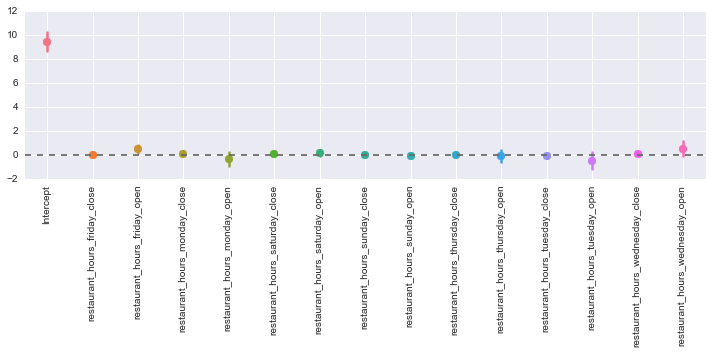

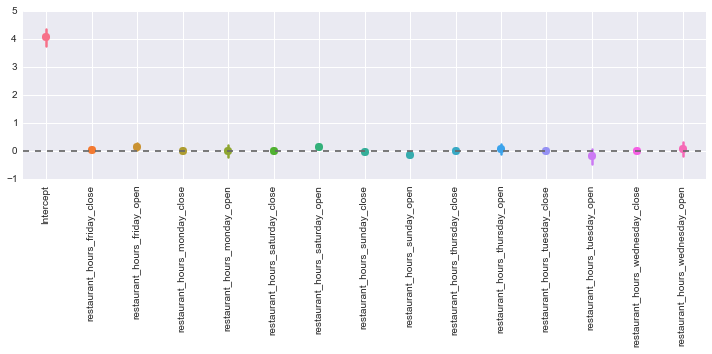

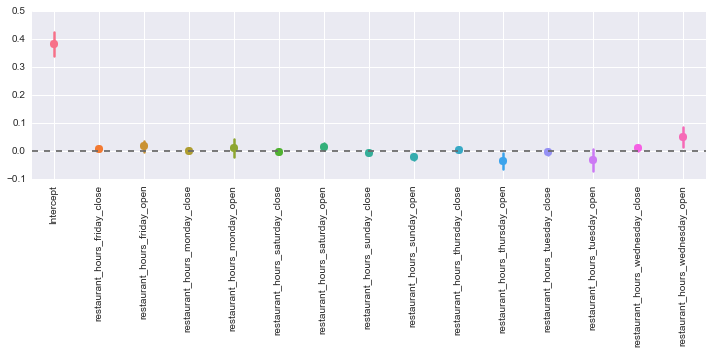

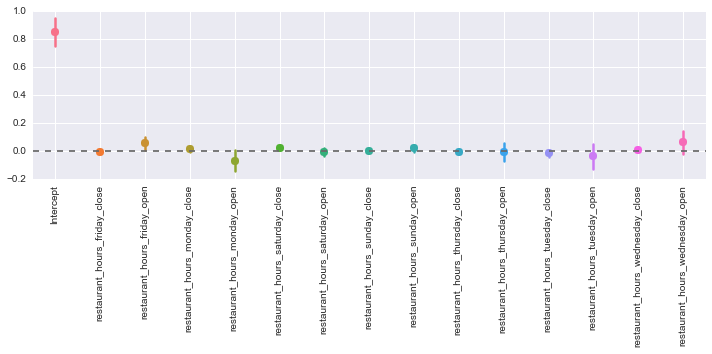

In [281]:
hours = X[['restaurant_hours_friday_close',
 'restaurant_hours_friday_open',
 'restaurant_hours_monday_close',
 'restaurant_hours_monday_open',
 'restaurant_hours_saturday_close',
 'restaurant_hours_saturday_open',
 'restaurant_hours_sunday_close',
 'restaurant_hours_sunday_open',
 'restaurant_hours_thursday_close',
 'restaurant_hours_thursday_open',
 'restaurant_hours_tuesday_close',
 'restaurant_hours_tuesday_open',
 'restaurant_hours_wednesday_close',
 'restaurant_hours_wednesday_open',]]
sns.mpl.rc("figure", figsize=(8,10))
X_formula = " + ".join([i for i in hours.columns.tolist()])

scores = ['transformed_score', 'score_lvl_1', 'score_lvl_2', 'score_lvl_3']
for score in scores:
    formula = score + " ~ " + X_formula
    print("\n* Formula: {}".format(formula))

    # seaborn can't handle categorical data so have to convert_objects first
    g = sns.coefplot(formula, data.convert_objects(), intercept=True)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('visuals/opening_closing_hours_coefficients_' + score)

sns.mpl.rc("figure", figsize=(14,10))


* Formula: transformed_score ~ restaurant_attributes_accepts_credit_cards + restaurant_attributes_ages_allowed + restaurant_attributes_alcohol + restaurant_attributes_attire + restaurant_attributes_byob + restaurant_attributes_byob_corkage + restaurant_attributes_by_appointment_only + restaurant_attributes_caters + restaurant_attributes_coat_check + restaurant_attributes_corkage + restaurant_attributes_delivery + restaurant_attributes_dietary_restrictions_dairy_free + restaurant_attributes_dietary_restrictions_gluten_free + restaurant_attributes_dietary_restrictions_halal + restaurant_attributes_dietary_restrictions_kosher + restaurant_attributes_dietary_restrictions_soy_free + restaurant_attributes_dietary_restrictions_vegan + restaurant_attributes_dietary_restrictions_vegetarian + restaurant_attributes_dogs_allowed + restaurant_attributes_drive_thr + restaurant_attributes_good_for_dancing + restaurant_attributes_good_for_groups + restaurant_attributes_good_for_breakfast + restaurant

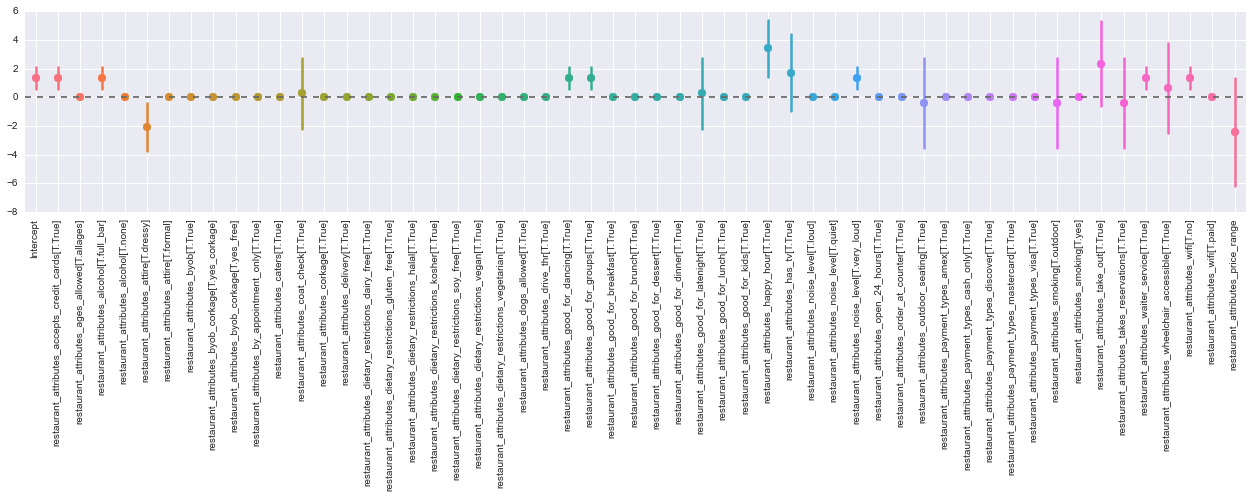

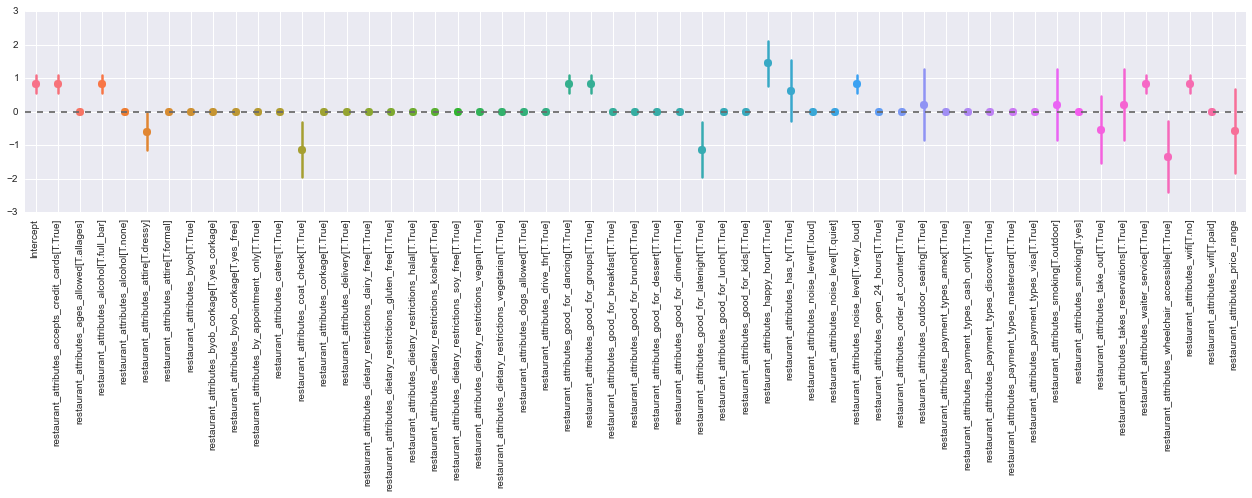

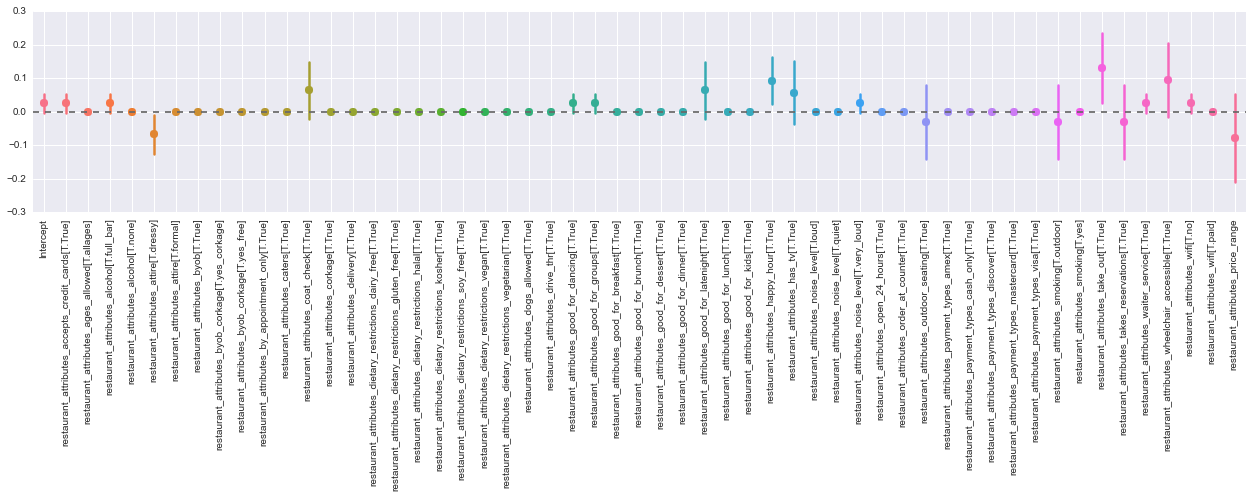

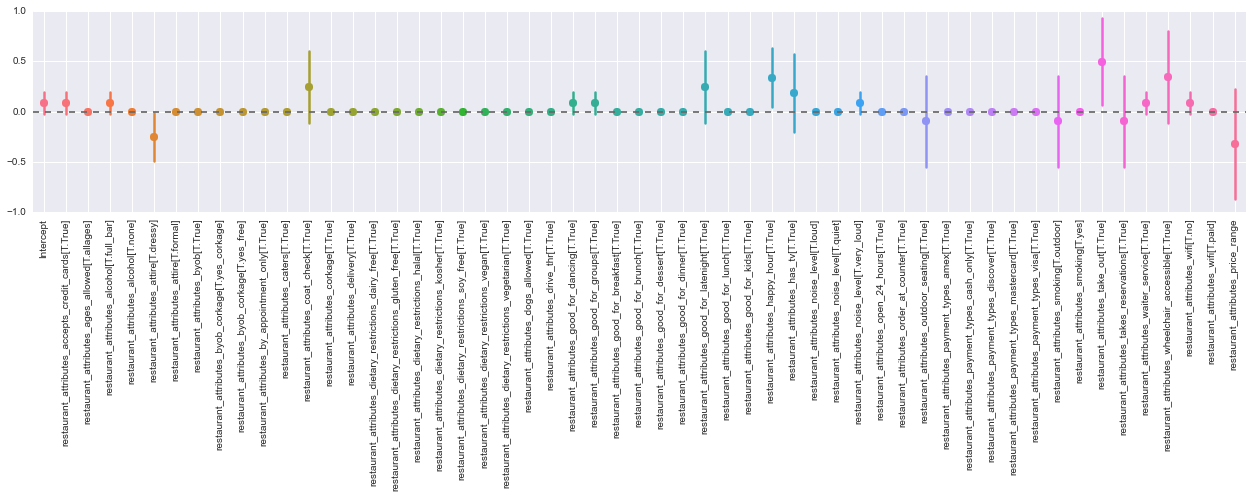

In [285]:
atts = X[['restaurant_attributes_accepts_credit_cards',
 'restaurant_attributes_ages_allowed',
 'restaurant_attributes_alcohol',
 'restaurant_attributes_attire',
 'restaurant_attributes_byob',
 'restaurant_attributes_byob_corkage',
 'restaurant_attributes_by_appointment_only',
 'restaurant_attributes_caters',
 'restaurant_attributes_coat_check',
 'restaurant_attributes_corkage',
 'restaurant_attributes_delivery',
 'restaurant_attributes_dietary_restrictions_dairy_free',
 'restaurant_attributes_dietary_restrictions_gluten_free',
 'restaurant_attributes_dietary_restrictions_halal',
 'restaurant_attributes_dietary_restrictions_kosher',
 'restaurant_attributes_dietary_restrictions_soy_free',
 'restaurant_attributes_dietary_restrictions_vegan',
 'restaurant_attributes_dietary_restrictions_vegetarian',
 'restaurant_attributes_dogs_allowed',
 'restaurant_attributes_drive_thr',
 'restaurant_attributes_good_for_dancing',
 'restaurant_attributes_good_for_groups',
 'restaurant_attributes_good_for_breakfast',
 'restaurant_attributes_good_for_brunch',
 'restaurant_attributes_good_for_dessert',
 'restaurant_attributes_good_for_dinner',
 'restaurant_attributes_good_for_latenight',
 'restaurant_attributes_good_for_lunch',
 'restaurant_attributes_good_for_kids',
 'restaurant_attributes_happy_hour',
 'restaurant_attributes_has_tv',
 'restaurant_attributes_noise_level',
 'restaurant_attributes_open_24_hours',
 'restaurant_attributes_order_at_counter',
 'restaurant_attributes_outdoor_seating',
 'restaurant_attributes_payment_types_amex',
 'restaurant_attributes_payment_types_cash_only',
 'restaurant_attributes_payment_types_discover',
 'restaurant_attributes_payment_types_mastercard',
 'restaurant_attributes_payment_types_visa',
 'restaurant_attributes_price_range',
 'restaurant_attributes_smoking',
 'restaurant_attributes_take_out',
 'restaurant_attributes_takes_reservations',
 'restaurant_attributes_waiter_service',
 'restaurant_attributes_wheelchair_accessible',
 'restaurant_attributes_wifi']]
sns.mpl.rc("figure", figsize=(14,14))
X_formula = " + ".join([i for i in atts.columns.tolist()])

scores = ['transformed_score', 'score_lvl_1', 'score_lvl_2', 'score_lvl_3']
for score in scores:
    formula = score + " ~ " + X_formula
    print("\n* Formula: {}".format(formula))

    # seaborn can't handle categorical data so have to convert_objects first
    g = sns.coefplot(formula, data.convert_objects(), intercept=True)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('visuals/restaurant_attributes_coefficients_' + score)

sns.mpl.rc("figure", figsize=(14,10))


* Formula: transformed_score ~ restaurant_stars + restaurant_city + restaurant_latitude + restaurant_longitude + restaurant_review_count + checkin_counts


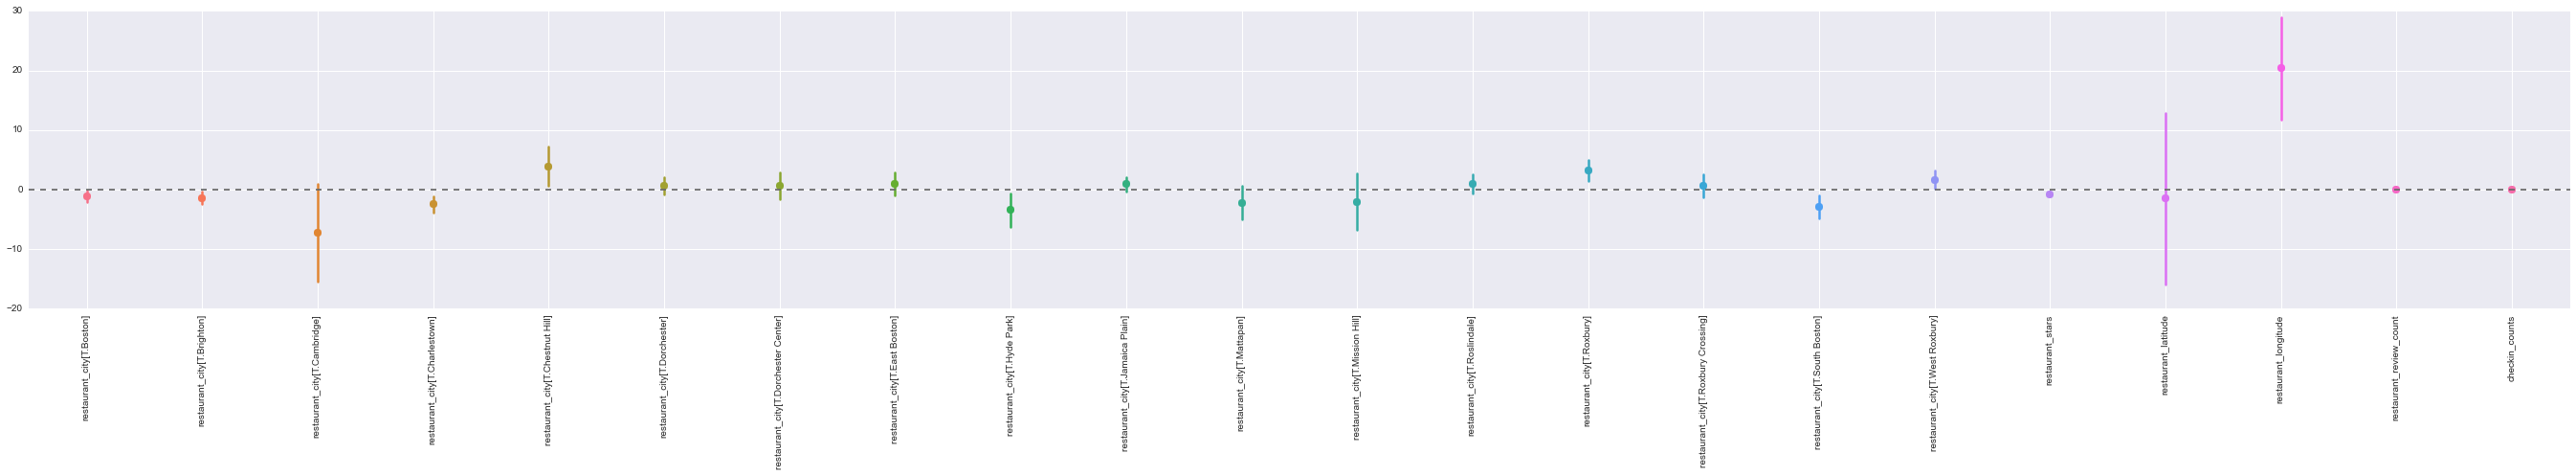

In [295]:
sns.mpl.rc("figure", figsize=(30,14))
# X_formula = " * ".join([i for i in selects.columns.tolist()])
X_formula = " + ".join([i for i in selects.columns.tolist()])
formula = 'transformed_score' + " ~ " + X_formula
print("\n* Formula: {}".format(formula))

# seaborn can't handle categorical data so have to convert_objects first
g = sns.coefplot(formula, data.convert_objects(), intercept=False)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('coefplot')

sns.mpl.rc("figure", figsize=(14,10))

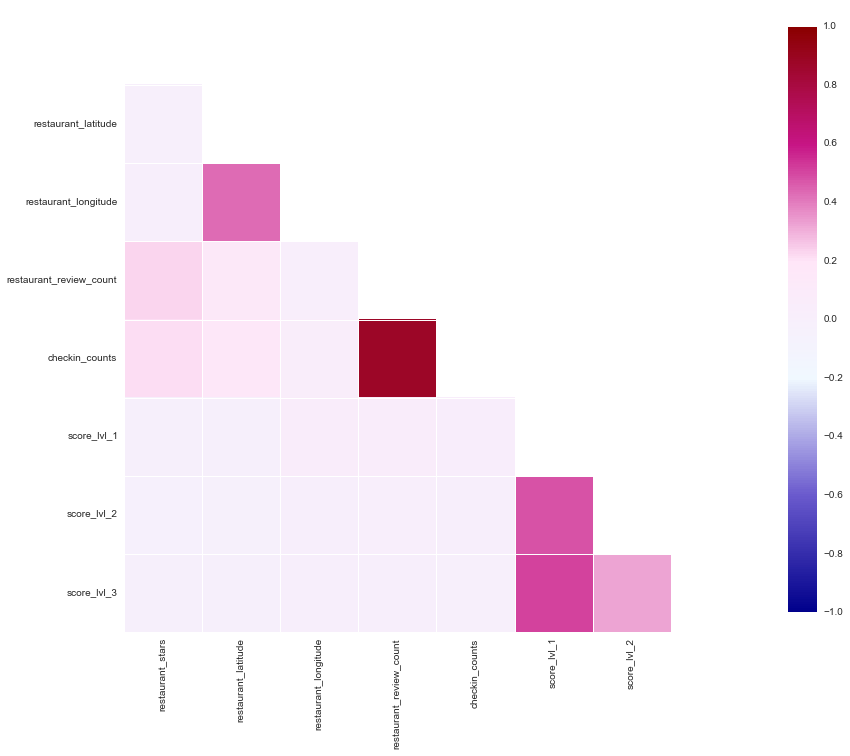

In [303]:
f, ax = plt.subplots(figsize=(14,14))
cmap = sns.blend_palette(["#00008B", "#6A5ACD", "#F0F8FF",
                          "#FFE6F8", "#C71585", "#8B0000"], as_cmap=True)
sns.corrplot(pd.concat([selects, y], axis=1), annot=False, diag_names=False, cmap=cmap)
ax.grid(False)

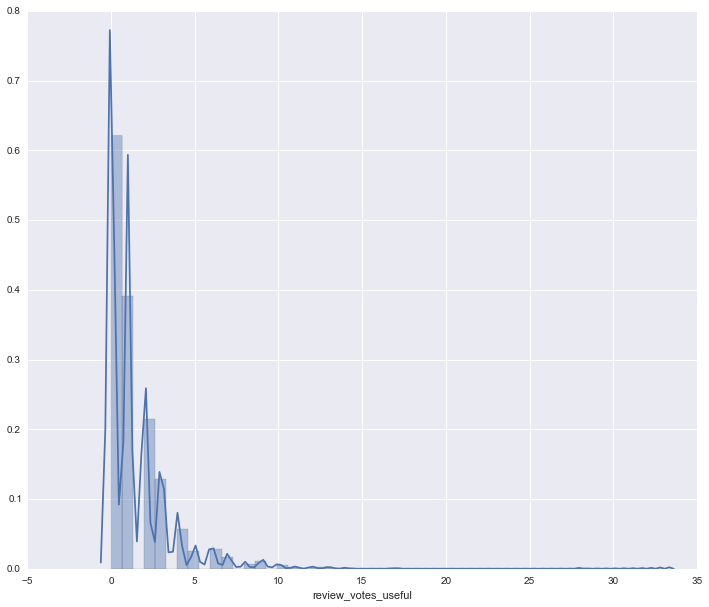

In [173]:
sns.distplot(X.review_votes_useful)

ValueError: could not convert string to float: (1037, 1087]

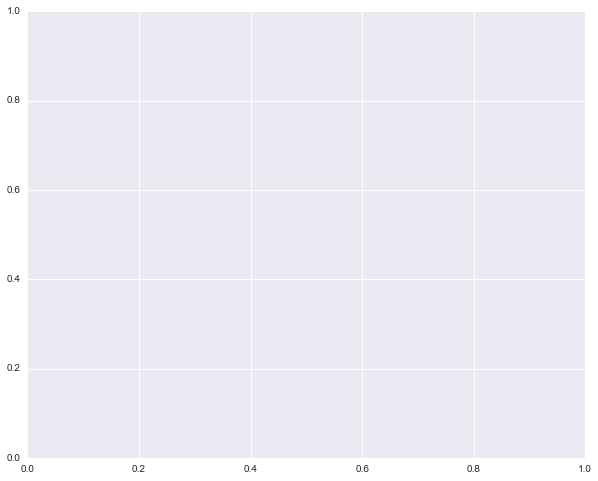

In [27]:
plt.plot(X[['time_delta_bin']], y)